In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import anndata as an
import scanpy.external as sce
import scipy
import scipy.sparse as sp
import time
import sklearn
import torch
from scipy.sparse import csr_matrix

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

In [2]:
print(torch.version.cuda) 

12.0


In [3]:
# Check CUDA availability
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

        # Additional information (compute capability, memory)
        gpu_props = torch.cuda.get_device_properties(i)
        print(f"  Compute Capability: {gpu_props.major}.{gpu_props.minor}")
        print(f"  Total Memory: {gpu_props.total_memory / 1024**3:.2f} GB")
else:
    print("CUDA not available. Running on CPU.")

CUDA available: True
Number of GPUs: 1
GPU 0: NVIDIA A100 80GB PCIe MIG 3g.40gb
  Compute Capability: 8.0
  Total Memory: 39.25 GB


In [4]:
# Check JAX

import jax
print(jax.devices())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]


# Load data

In [5]:
def load_annotations(fpath):
    """
    Loads annotations data from a CSV file, processes it, and returns the resulting DataFrame.

    Args:
        fpath (str): The file path to the CSV file containing annotations data.

    Returns:
        pd.DataFrame: The processed DataFrame with 'cell_id' as the index.
    """
    df = pd.read_csv(fpath)
    df['cell_id'] = df['obs_index'].astype(str) + "_" + df["dataset"]
    df = df.drop(columns='dataset')
    df = df.set_index('cell_id')
    return df

In [6]:
"""
DATA
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/merged_anndata/merged_adata.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
print(adata)

"""
ANNOTATIONS
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/annotation/cell_types.csv"
df = load_annotations(fpath)
df = df[df.index.isin(adata.obs_names)]
print(f"{df.shape=}")

adata.obs = pd.concat([adata.obs, df], ignore_index=False, axis=1)
adata

Memory usage: current 8.73 GB, difference +8.73 GB
AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'
df.shape=(171498, 3)


AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

# Annotations

In [7]:
# fpaths = [
#     "../resources/PanglaoDB_Augmented_2021.txt",
#     "../resources/Tabula_Sapiens.txt",
# ]

# marker_columns = []

# for fpath in fpaths:    
#     features = ut.load_pathway(fpath)

#     # extract columns
#     hsc_columns = [x for x in features.columns if "hemato" in x.lower()]
#     fib_columns = [x for x in features.columns if "fibroblast" in x.lower()]
#     fib_columns = [x for x in fib_columns if not "myofibr" in x.lower()]
    
#     columns = list(set(hsc_columns + fib_columns))

#     for col in columns:
#         gene_list = list(features[features[col].astype(bool)].index)
#         print(col, len(gene_list))
#         col_name = col.lower().replace("-", " ")
#         col_name = col_name.replace(" ", "_") + "_marker"
#         marker_columns.append(col_name)
#         adata.var[col_name] = adata.var.index.isin(gene_list)
    
# adata.var['is_marker'] = adata.var[marker_columns].any(axis=1)
# print()
# adata

# Randomly subsample the tabula sapiens fibroblast data

In [8]:
# sample_size = 1e4 # the numbner of fibroblast signatures to keep

# mask = (adata.obs['dataset'] == 'tabula_sapiens') & (adata.obs['standard_cell_type'] == 'Fib')

# print(f"Filtering for Fibroblasts from tabula_sapiens dataset...")
# fibdf = adata.obs[mask].copy()
# print(f"Found {len(fibdf)} fibroblasts.")

# print(f"Sampling {sample_size} fibroblasts...")
# keep = fibdf.sample(int(sample_size))
# keep = keep.index
# print("Sampling complete.")

# fib_to_drop = fibdf[~fibdf.index.isin(keep)].index
# all_keep = ~adata.obs.index.isin(fib_to_drop)

# # Print the lengths
# print(f"Total fibroblasts: {len(adata.obs.index)}")
# print(f"Fibroblasts to keep: {len(keep)}")
# print(f"Fibroblasts to drop: {len(fib_to_drop)}") 

# adata = adata[all_keep, :].copy()  
# adata

# Cell type filtering

In [9]:
cell_types = [
    # 'PreBNK', - only preent in single batch
    # 'LinNeg', - only preent in single batch
    'HSC',
    'CMP',
    'MEP',
    'MPP',
    'GMP',
    # 'MLP', - only preent in single batch
    'EryP',
    'MDP',
    'MKP',
    'Mono',
    'CLP',
    'T_cell',
    'B_cell',
    'NK',
    'LMPP',
    'Dendritic_cell',
    'Fib',
    'iHSC',
]

adata = adata[adata.obs['standard_cell_type'].notna(), :].copy()
adata = adata[adata.obs['standard_cell_type'].isin(cell_types), :].copy()

adata.obs['standard_cell_type'].value_counts()

standard_cell_type
Fib               34289
HSC               20789
T_cell            19303
B_cell            10734
EryP               9902
MPP                9391
iHSC               8379
MEP                7433
Mono               6988
GMP                4882
NK                 4189
MDP                3989
MKP                3980
CLP                3640
CMP                2804
Dendritic_cell     2694
LMPP                805
Name: count, dtype: int64

# Preprocessing

In [10]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=5)

adata

filtered out 17113 cells that have less than 1000 genes expressed
filtered out 38 genes that are detected in less than 5 cells


AnnData object with n_obs × n_vars = 137078 × 18829
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    layers: 'counts'

In [11]:
# Normalizing to median total counts
target_sum = 1e4
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)
adata.layers["log_norm"] = csr_matrix(adata.X.astype('float32').copy())

adata

normalizing counts per cell
    finished (0:00:02)


AnnData object with n_obs × n_vars = 137078 × 18829
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'log_norm'

# Make reference and query data

In [12]:
reference_data = [
    'tabula_sapiens',
    'weng_young2_all',
    'sc_fib',
    'weng_young1_all_t2',
    'weng_young1_all_t1',
]

query_data = [
    'iHSC',
]

sample_size = None

# define data sets
rdata = adata[adata.obs['dataset'].isin(reference_data), :].copy()
if not sample_size is None:
    sc.pp.subsample(rdata, n_obs=sample_size)

print(rdata)
print()
qdata = adata[adata.obs['dataset'].isin(query_data), :].copy()
print(qdata)

AnnData object with n_obs × n_vars = 100058 × 18829
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'log_norm'

AnnData object with n_obs × n_vars = 8131 × 18829
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'log_norm'


In [13]:
rdata.obs['cell_label'] = rdata.obs['standard_cell_type'].apply(lambda x: str(x).strip())
rdata.obs['cell_label'].value_counts()

cell_label
Fib               33710
HSC               14639
T_cell             9792
MPP                7459
B_cell             5363
MEP                5142
EryP               4927
NK                 3515
CLP                3125
MKP                3120
GMP                2537
Mono               2352
MDP                2064
CMP                1155
LMPP                716
Dendritic_cell      442
Name: count, dtype: int64

In [14]:
qdata.obs['cell_label'] = 'Unknown'
qdata.obs['cell_label'].value_counts()

cell_label
Unknown    8131
Name: count, dtype: int64

# Reference Mapping (scANVI)

In [15]:
n_genes = 2000

rdata.raw = rdata
sc.pp.highly_variable_genes(
    rdata, 
    n_top_genes=n_genes,
    batch_key="dataset", 
    subset=True,
    layer='log_norm',
)

extracting highly variable genes
    finished (0:00:13)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
scvi.model.SCVI.setup_anndata(
    rdata, 
    batch_key="dataset",
    layer="counts",
    labels_key='cell_label',
)

In [17]:
torch.cuda.empty_cache()

epochs = 30

model = scvi.model.SCVI(
    rdata,
    use_layer_norm="both",
    use_batch_norm="none",
    n_latent=10,
    encode_covariates=True,
    dropout_rate=0.3,
    n_layers=2,
)

start_time = time.time()  # Record the start time

model.train(
    max_epochs=epochs,
    accelerator='gpu',
    devices='auto',
)

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total execution time

print(f"Training completed in {total_time:.2f} seconds")

# Optional: More detailed timing information
minutes = int(total_time // 60)
seconds = int(total_time % 60)
print(f"Training time: {minutes} minutes {seconds} seconds")

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium'

Training:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Training completed in 189.61 seconds
Training time: 3 minutes 9 seconds


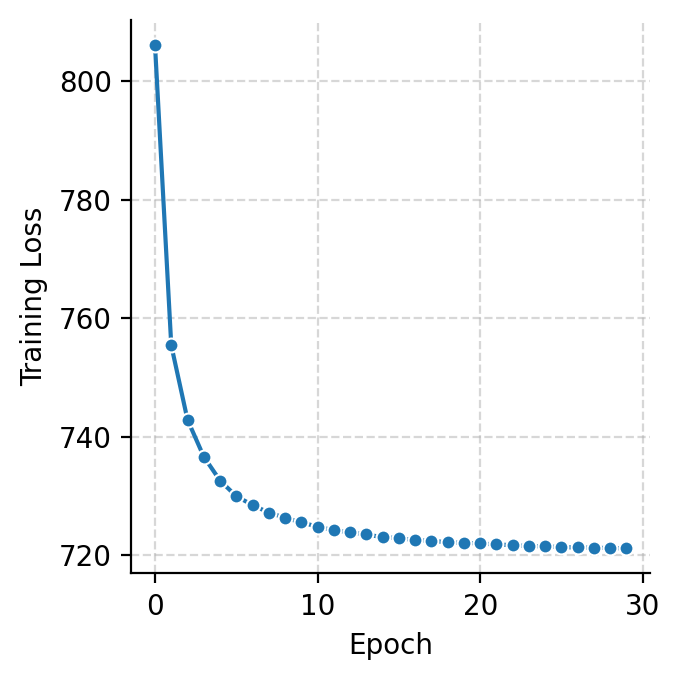

In [18]:
metrics = pd.concat(
    model.history.values(), 
    ignore_index=False,
    axis=1
)

metrics = metrics.reset_index()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=metrics,
    x='epoch',
    y='train_loss_epoch',
    linewidth=1.5,               
    marker='o',          
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks()
plt.yticks()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# SCVI Latent Space

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
running Leiden clustering


/tmp/ipykernel_3762709/1048822739.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 16 clusters and added
    'scvi_clusters', the cluster labels (adata.obs, categorical) (0:00:24)
computing UMAP


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_umap.py:231: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


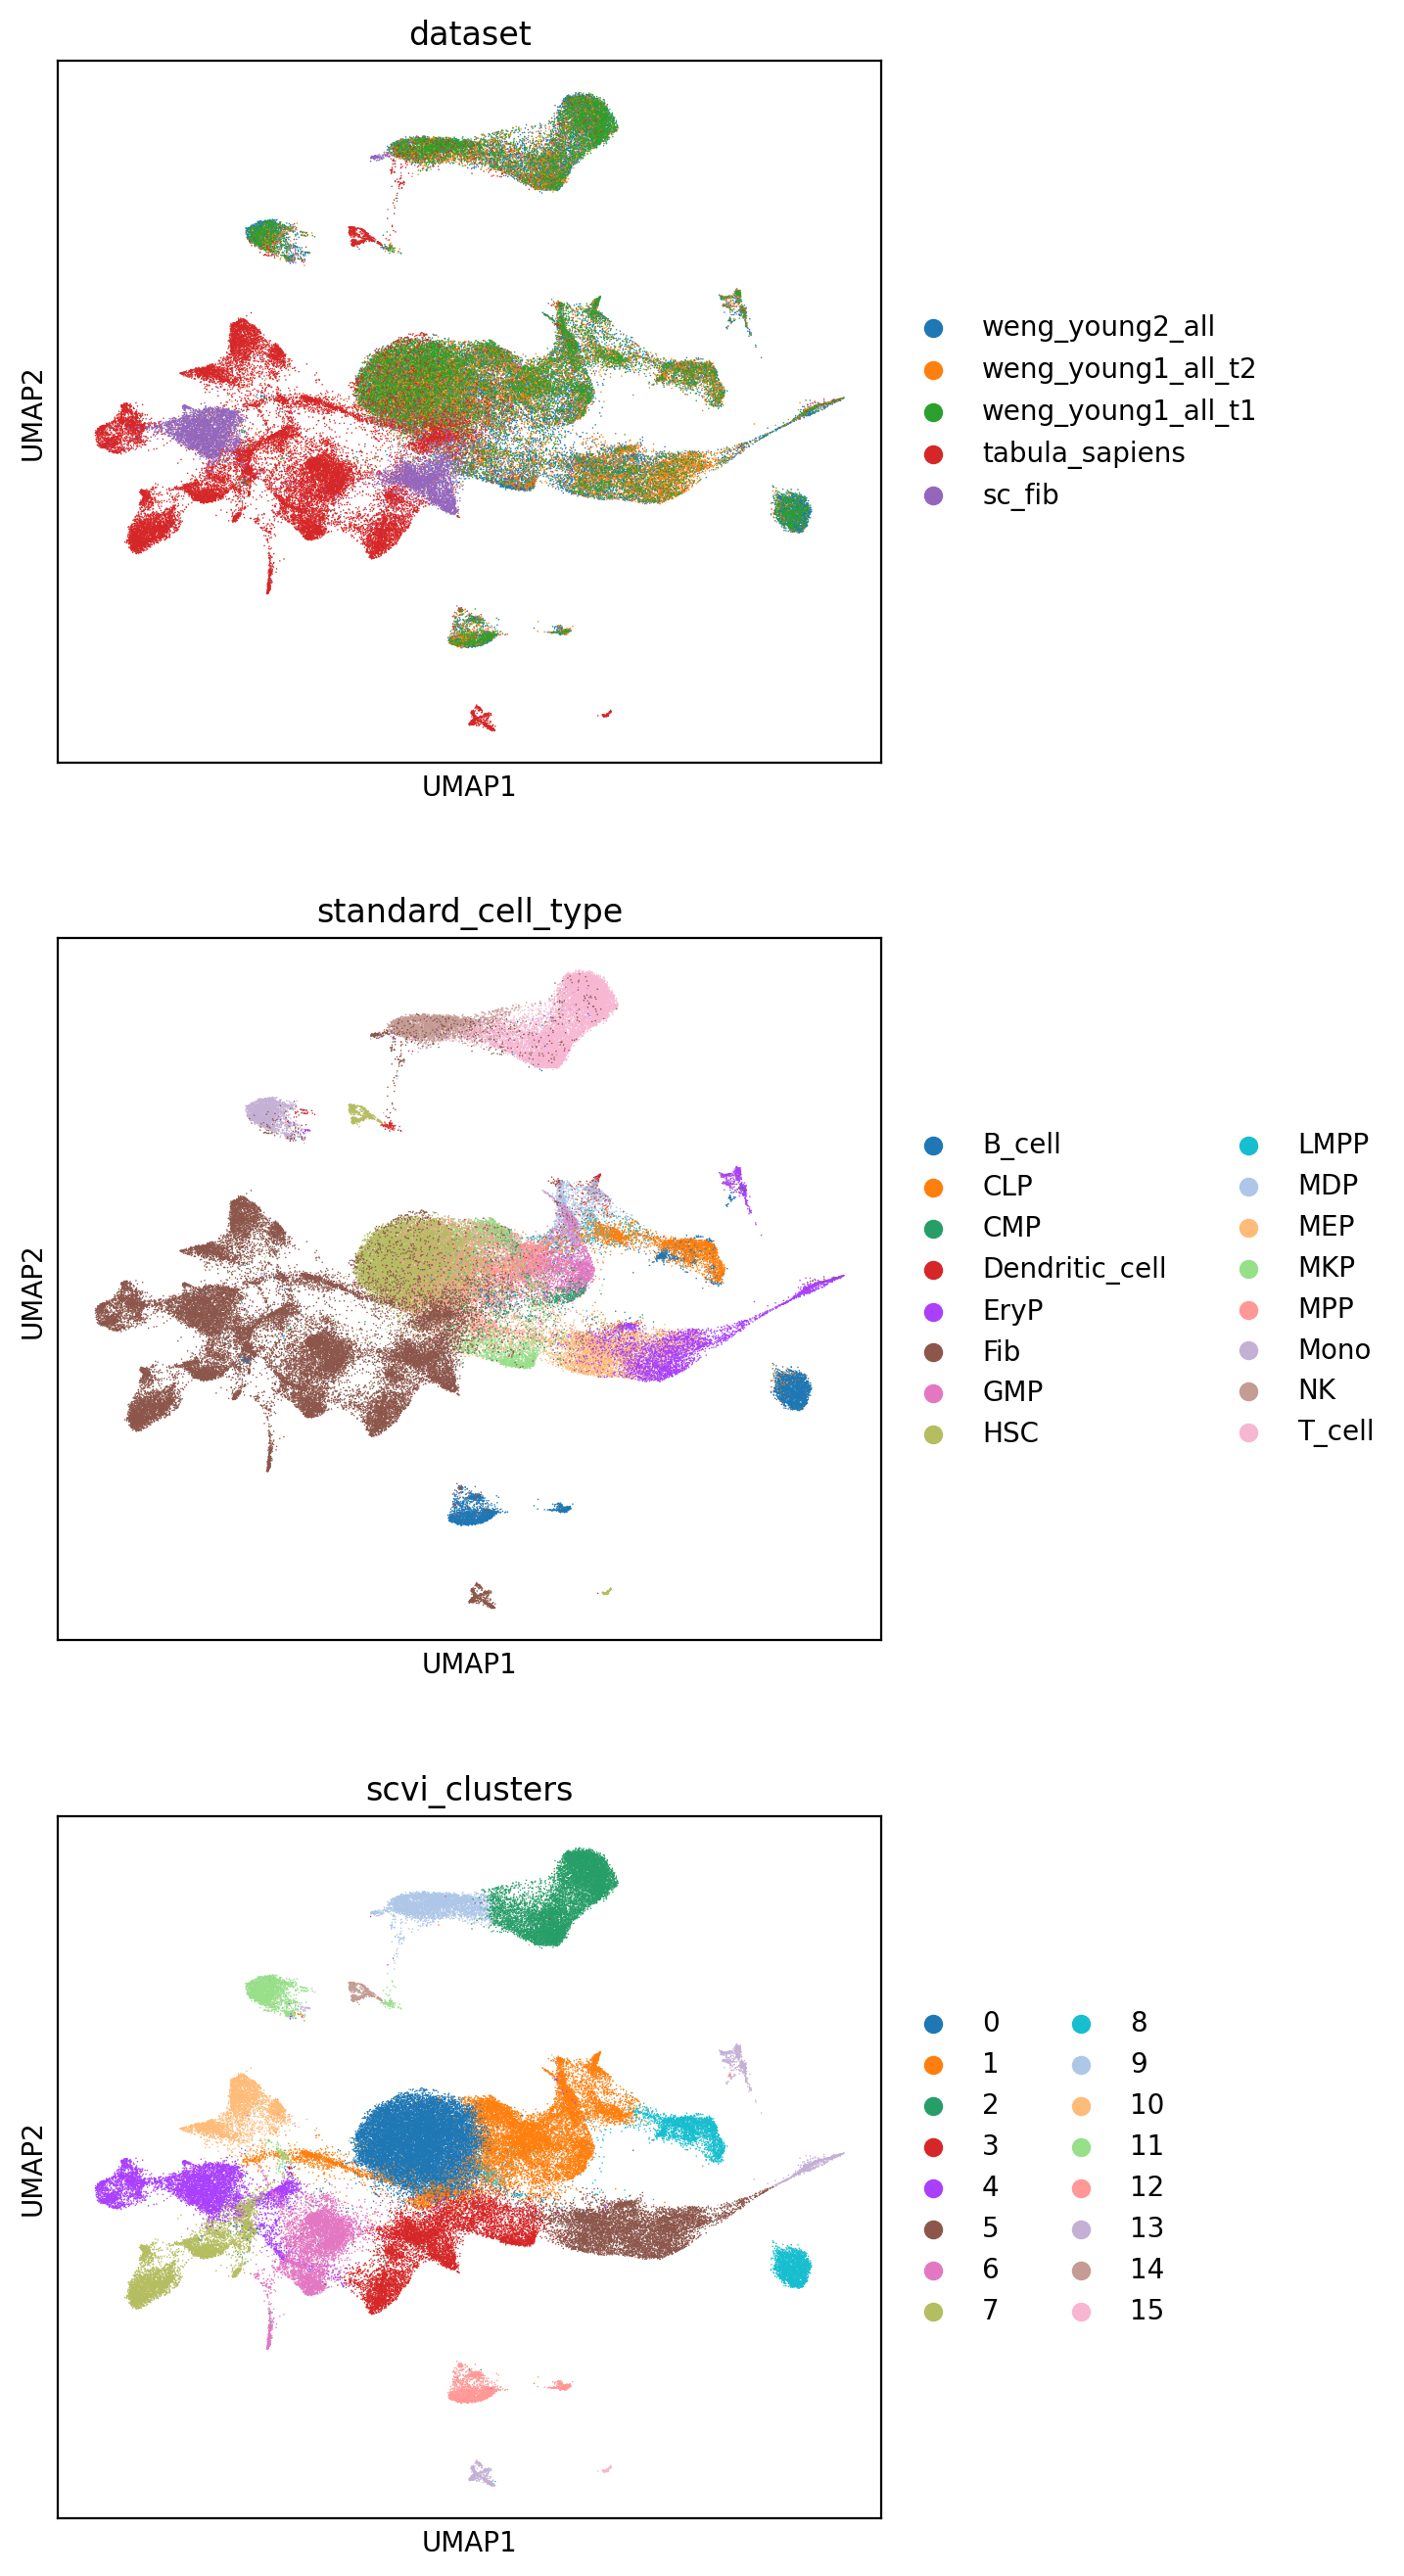

In [19]:
SCVI_LATENT_KEY = "X_scVI"
rdata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

sc.pp.neighbors(
    rdata, 
    use_rep=SCVI_LATENT_KEY,
)

sc.tl.leiden(
    rdata, 
    resolution=0.3,
    key_added='scvi_clusters',
)

sc.tl.umap(
    rdata,
    min_dist=0.25,
    method='rapids',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    rdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'scvi_clusters',
    ],
    ncols=1,
)

In [20]:
# break

# SCANVI Model

In [21]:
torch.cuda.empty_cache()

# train the scanvi model
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model, 
    unlabeled_category="Unknown",
)

epochs = 100

scanvi_model.train(
    max_epochs=epochs,
    accelerator='gpu',
    devices='auto',
)

INFO     Training for 100 epochs.                                                                                  


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-cfb2a8ae-864b-50df-94a5-98983023f29d]
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/pytorch/trainer/

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


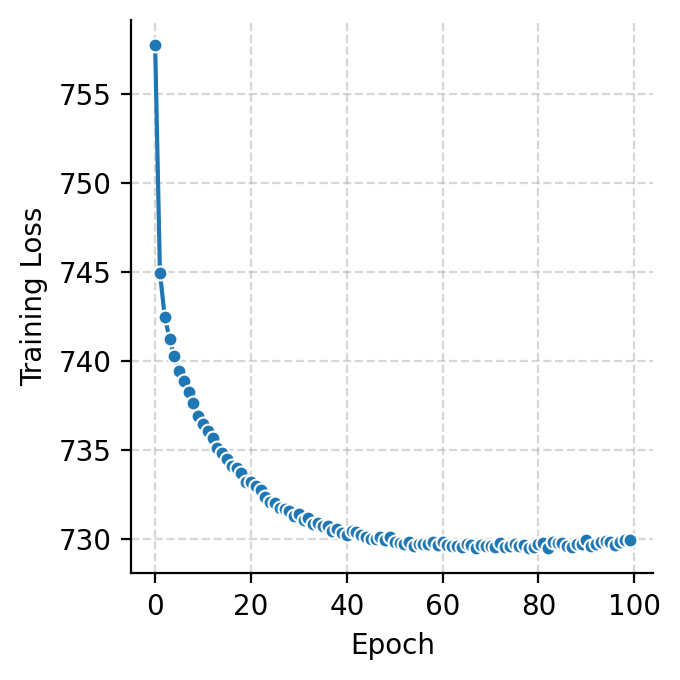

In [22]:
metrics = pd.concat(
    scanvi_model.history.values(), 
    ignore_index=False,
    axis=1
)
metrics = metrics.reset_index()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=metrics,
    x='epoch',
    y='train_loss_epoch',
    linewidth=1.5,               
    marker='o',          
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks()
plt.yticks()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Latent Representations (SCANVI)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Leiden clustering
    finished: found 23 clusters and added
    'scanvi_clusters', the cluster labels (adata.obs, categorical) (0:00:10)
computing UMAP


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_umap.py:231: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


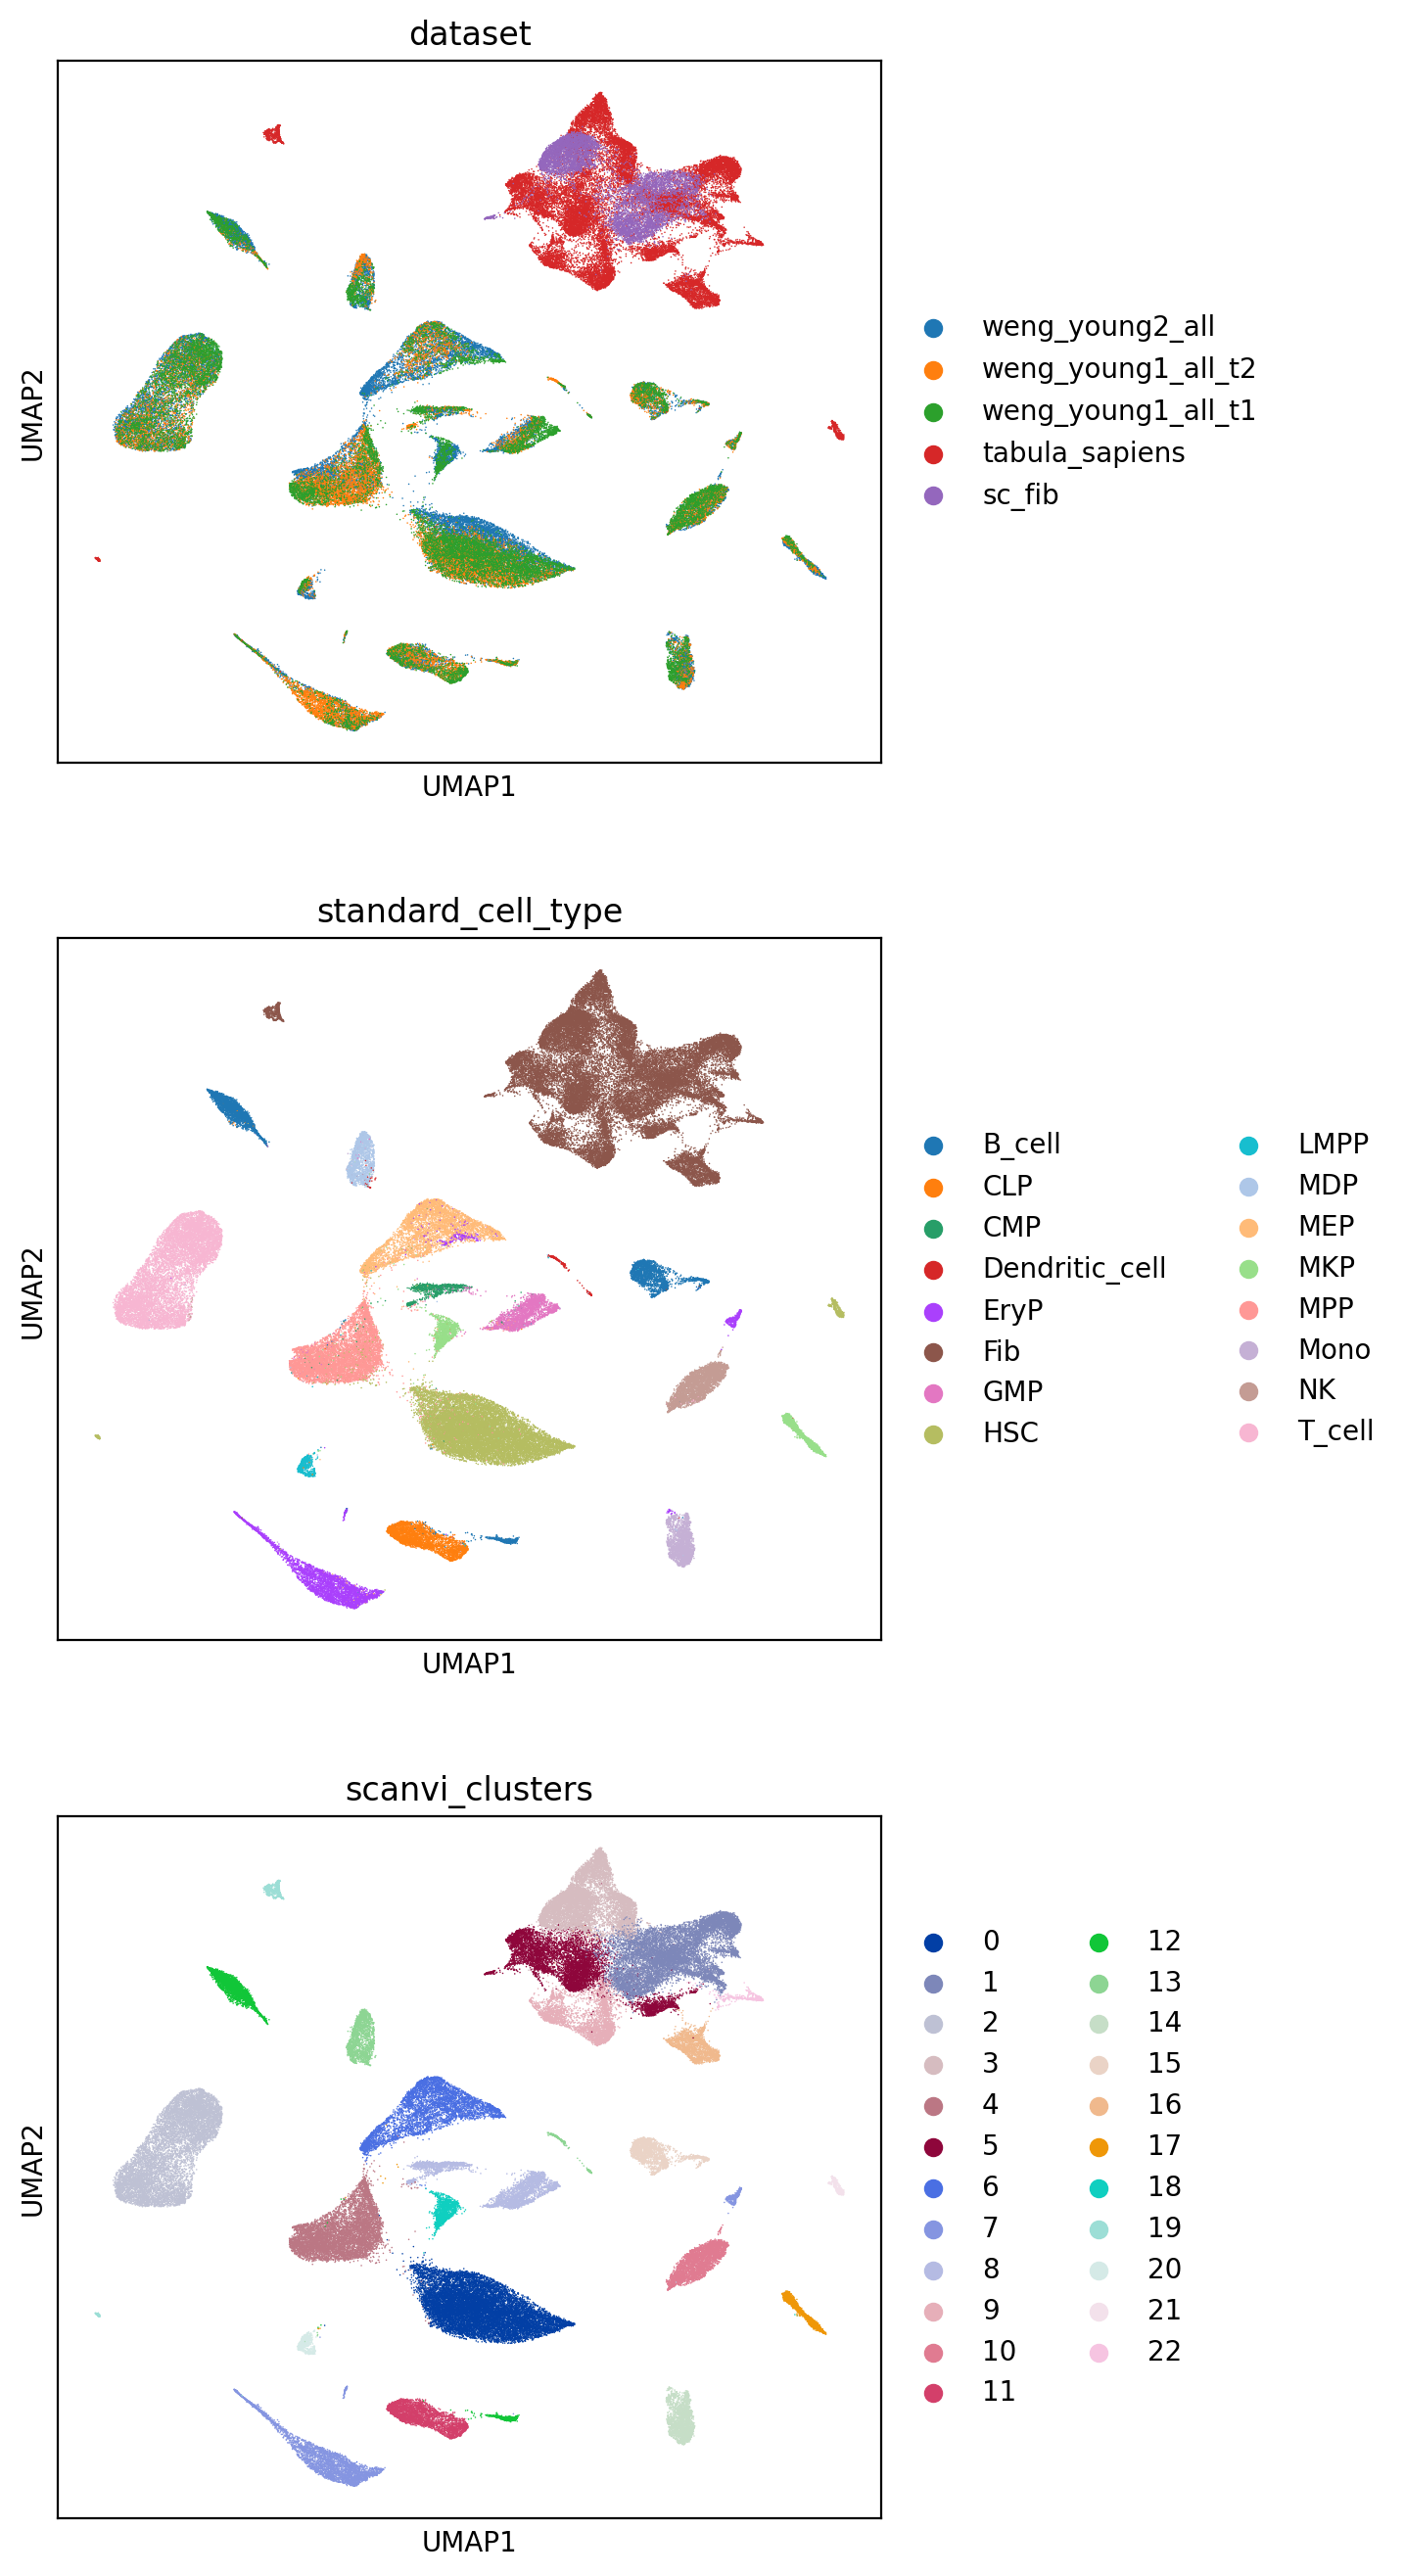

In [23]:
SCANVI_LATENT_KEY = "X_scANVI"

rdata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()

sc.pp.neighbors(
    rdata, 
    use_rep=SCANVI_LATENT_KEY,
)

sc.tl.leiden(
    rdata, 
    resolution=0.3,
    key_added='scanvi_clusters',
)

sc.tl.umap(
    rdata,
    min_dist=0.25,
    method='rapids',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    rdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'scanvi_clusters',
    ],
    ncols=1,
)

In [24]:
rdata.layers['SCANVI_counts'] = scanvi_model.get_normalized_expression(return_mean=False)
rdata

AnnData object with n_obs × n_vars = 100058 × 2000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'scvi_clusters', 'scanvi_clusters'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'scvi_clusters', 'umap', 'dataset_colors', 'standard_cell_type_colors', 'scvi_clusters_colors', 'scanvi_clusters', 'scanvi_clusters_colors'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    layers: 'counts', 'log_norm', 'SCANVI_counts'
    obsp: 'distances', 'connectivities'

# Save the model (SCANVI only)

In [25]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/model/"
scanvi_model.save(
    fpath, 
    overwrite=True, 
    save_anndata=True,
    prefix='reference_'
) 
print('done')

done


# Benchmarking

computing PCA
    with n_comps=50


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:27)


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Embeddings: 100%|██████████| 3/3 [18:20<00:00, 366.71s/it]tch correction: pcr_comparison]

                                                                                         

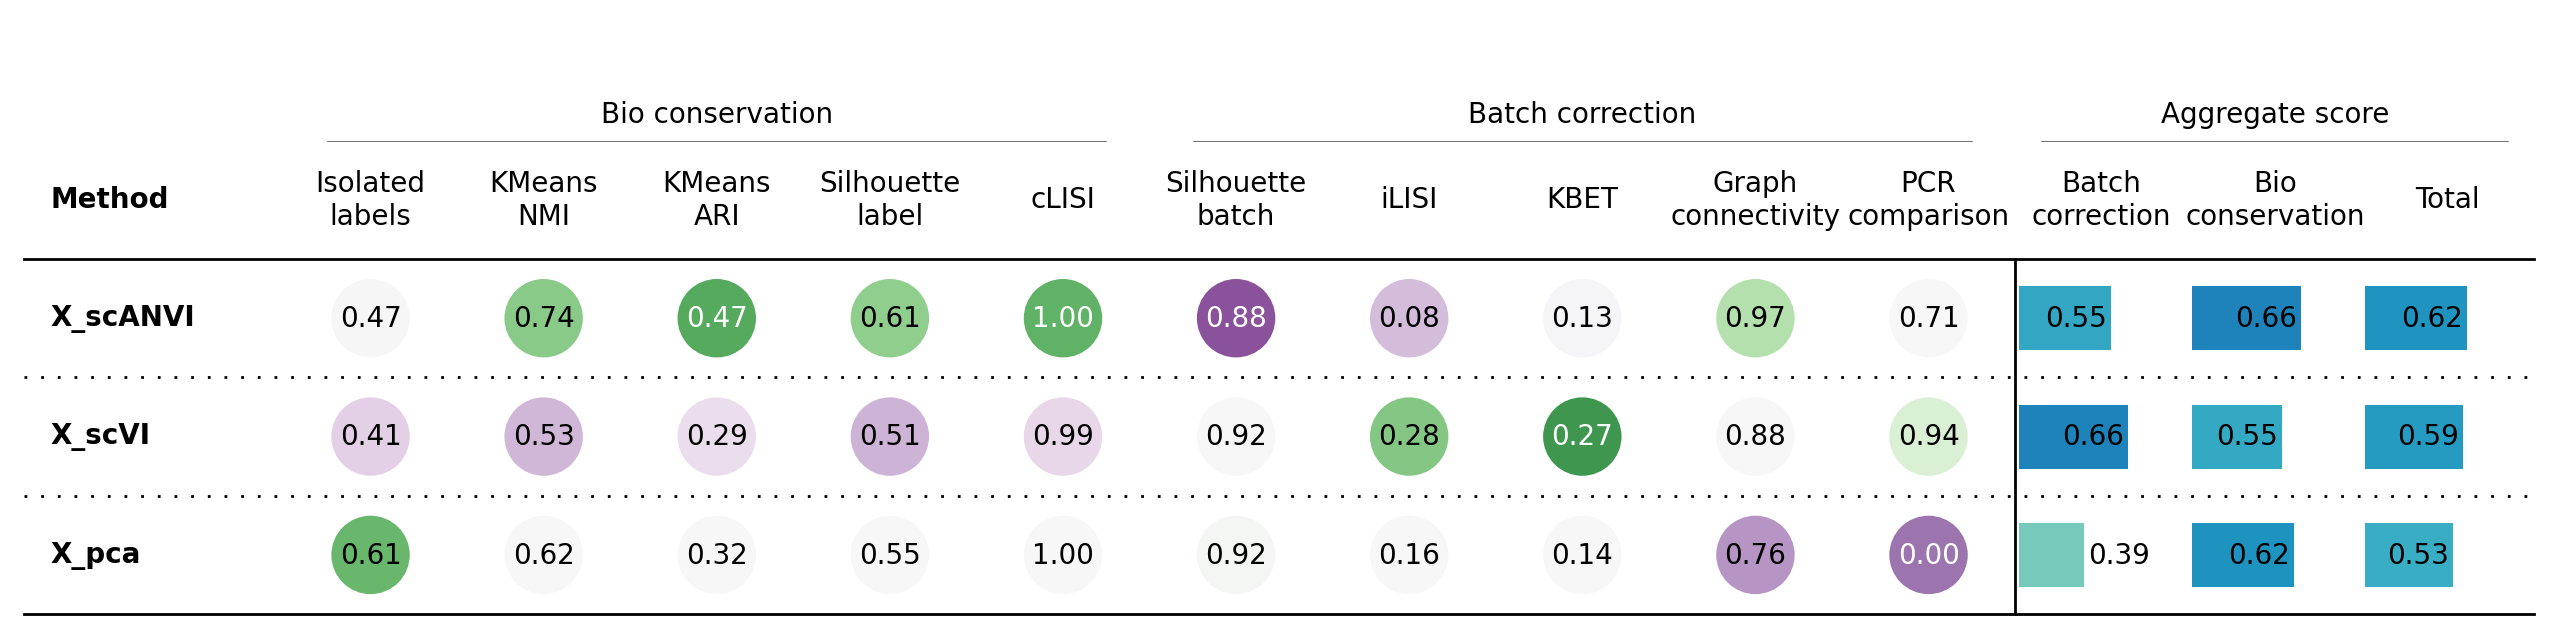

In [27]:
from scib_metrics.benchmark import Benchmarker

torch.cuda.empty_cache()

bm = Benchmarker(
    rdata,
    batch_key="dataset",
    label_key="cell_label",
    embedding_obsm_keys=['X_pca', SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)

bm.benchmark()

bm.plot_results_table(min_max_scale=False)

In [28]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/benchmarks.csv"
bmdf = bm.get_results(min_max_scale=False)
bmdf = bmdf.reset_index(drop=False,)
bmdf.to_csv(fpath, index=False,)
bmdf.head()

,Embedding,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
0,X_pca,0.612225,0.615393,0.322691,0.550254,0.99558,0.917604,0.157412,0.136664,0.758546,0.0,0.394045,0.619229,0.529155
1,X_scVI,0.413957,0.525646,0.287769,0.508328,0.994179,0.916301,0.284725,0.269333,0.879817,0.941486,0.658332,0.545976,0.590918
2,X_scANVI,0.469755,0.744508,0.470645,0.605696,1.0,0.878373,0.078078,0.132746,0.971784,0.709219,0.55404,0.658121,0.616488
3,Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [ ]:
# break

# Query mapping (SCANVI)

In [29]:
scvi.model.SCANVI.prepare_query_anndata(
    qdata, 
    scanvi_model,
)

scanvi_query = scvi.model.SCANVI.load_query_data(
    qdata, 
    scanvi_model,
)

print('Done!')

torch.cuda.empty_cache()

epochs = 15

SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

scanvi_query.train(
    max_epochs=epochs, 
    plan_kwargs={"weight_decay": 0.01},
)

qdata.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
qdata.layers['SCANVI_counts'] = scanvi_query.get_normalized_expression(return_mean=False)
qdata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()

qdata

INFO     Found 100.0% reference vars in query data.                                                                
Done!
INFO     Training for 15 epochs.                                                                                   


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is n

Training:   0%|          | 0/15 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


AnnData object with n_obs × n_vars = 8131 × 2000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'predictions_scanvi'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scANVI'
    layers: 'counts', 'log_norm', 'SCANVI_counts'

In [30]:
"""ADD SCVI LATENT SPACE AS WELL"""

scvi.model.SCVI.prepare_query_anndata(
    qdata, 
    model,
)

scvi_query = scvi.model.SCVI.load_query_data(
    qdata, 
    model,
)

epochs = 15

scvi_query.train(
    max_epochs=epochs, 
    plan_kwargs={"weight_decay": 0.01},
)

qdata.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation()
qdata

INFO     Found 100.0% reference vars in query data.                                                                


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is n

Training:   0%|          | 0/15 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


AnnData object with n_obs × n_vars = 8131 × 2000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'predictions_scanvi'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scANVI', 'X_scVI'
    layers: 'counts', 'log_norm', 'SCANVI_counts'

# Store Query Model (SCANVI only)

In [31]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/model/"
scanvi_query.save(
    fpath, 
    overwrite=True, 
    save_anndata=True,
    prefix='query_'
) 
print('done')

done


# Predicted Probability

In [32]:
pred_proba = scanvi_query.predict(soft=True)
pred_proba.head()

,B_cell,CLP,CMP,Dendritic_cell,EryP,Fib,GMP,HSC,LMPP,MDP,MEP,MKP,MPP,Mono,NK,T_cell
AAACCCAAGGTTACCT_iHSC,0.000003,1.386789e-07,1.680963e-04,6.543802e-12,3.173824e-04,6.699879e-08,3.987735e-05,1.484036e-04,5.621219e-08,1.633217e-09,9.786865e-01,5.212478e-04,2.011509e-02,2.573257e-08,3.083955e-11,4.082157e-11
AAACCCAAGTTGAAGT_iHSC,0.000008,3.195175e-07,4.071204e-03,1.553325e-10,3.962660e-04,1.111963e-07,2.409458e-04,1.528049e-04,2.673145e-06,3.863895e-07,9.488198e-01,9.936767e-05,4.620714e-02,7.773186e-07,3.882630e-09,2.658818e-08
AAACCCAAGTTGTCGT_iHSC,0.000347,4.921812e-06,3.190439e-13,5.393191e-07,2.360342e-10,9.996465e-01,6.726907e-12,4.254928e-07,1.330744e-09,1.089295e-08,6.871657e-12,8.245360e-08,2.386840e-10,2.525420e-09,1.167162e-11,2.411123e-10
AAACCCACAGAAGCGT_iHSC,0.000014,5.983364e-10,1.477483e-09,3.509038e-08,1.593531e-05,9.952884e-01,3.474127e-09,9.791458e-09,4.635069e-08,2.264722e-06,9.070450e-09,4.263793e-07,1.314705e-12,4.563988e-03,7.227178e-06,1.081209e-04
AAACCCACAGGAGGTT_iHSC,0.000002,8.473036e-07,1.654608e-05,5.377911e-09,2.311429e-04,3.986088e-05,6.602365e-03,7.570811e-02,9.238606e-07,1.353237e-08,5.936084e-02,8.259122e-01,3.212544e-02,1.498043e-08,1.227018e-10,7.256188e-13


<Axes: xlabel='HSC', ylabel='Count'>

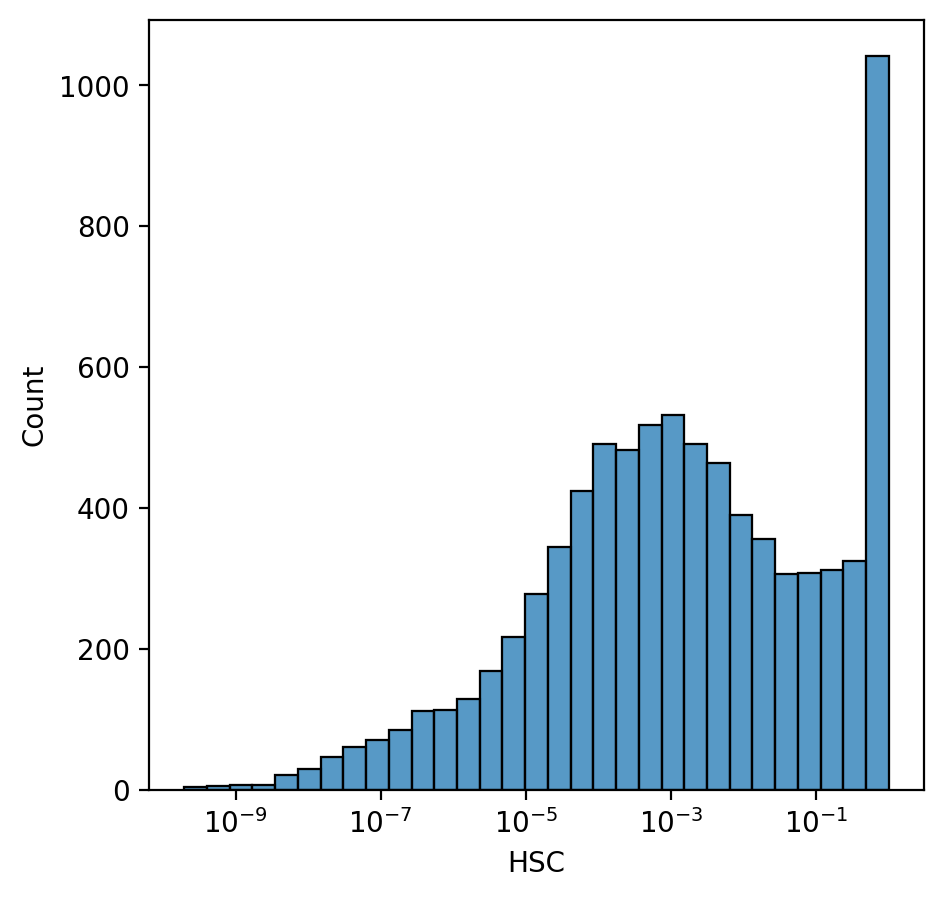

In [33]:
sns.histplot(
    data=pred_proba,
    x='HSC',
    log_scale=True,
    bins=31,
)

In [40]:
preds = scanvi_query.predict()
pd.value_counts(preds)

MEP               2972
Fib               1898
HSC               1102
MPP                888
MKP                612
CMP                472
GMP                 71
Mono                30
EryP                23
Dendritic_cell      18
B_cell              18
CLP                 15
MDP                  6
NK                   4
T_cell               2
Name: count, dtype: int64

# Store predictions

In [45]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/ihsc_predictions.csv"
df = pred_proba.copy()
df = df.astype(float)
df['prediction'] = df.idxmax(axis=1)
df = df.reset_index(drop=False, names='cell_id')

df.to_csv(fpath, index=False,)

df.head()

,cell_id,B_cell,CLP,CMP,Dendritic_cell,EryP,Fib,GMP,HSC,LMPP,MDP,MEP,MKP,MPP,Mono,NK,T_cell,prediction
0,AAACCCAAGGTTACCT_iHSC,0.000003,1.386789e-07,1.680963e-04,6.543802e-12,3.173824e-04,6.699879e-08,3.987735e-05,1.484036e-04,5.621219e-08,1.633217e-09,9.786865e-01,5.212478e-04,2.011509e-02,2.573257e-08,3.083955e-11,4.082157e-11,MEP
1,AAACCCAAGTTGAAGT_iHSC,0.000008,3.195175e-07,4.071204e-03,1.553325e-10,3.962660e-04,1.111963e-07,2.409458e-04,1.528049e-04,2.673145e-06,3.863895e-07,9.488198e-01,9.936767e-05,4.620714e-02,7.773186e-07,3.882630e-09,2.658818e-08,MEP
2,AAACCCAAGTTGTCGT_iHSC,0.000347,4.921812e-06,3.190439e-13,5.393191e-07,2.360342e-10,9.996465e-01,6.726907e-12,4.254928e-07,1.330744e-09,1.089295e-08,6.871657e-12,8.245360e-08,2.386840e-10,2.525420e-09,1.167162e-11,2.411123e-10,Fib
3,AAACCCACAGAAGCGT_iHSC,0.000014,5.983364e-10,1.477483e-09,3.509038e-08,1.593531e-05,9.952884e-01,3.474127e-09,9.791458e-09,4.635069e-08,2.264722e-06,9.070450e-09,4.263793e-07,1.314705e-12,4.563988e-03,7.227178e-06,1.081209e-04,Fib
4,AAACCCACAGGAGGTT_iHSC,0.000002,8.473036e-07,1.654608e-05,5.377911e-09,2.311429e-04,3.986088e-05,6.602365e-03,7.570811e-02,9.238606e-07,1.353237e-08,5.936084e-02,8.259122e-01,3.212544e-02,1.498043e-08,1.227018e-10,7.256188e-13,MKP


# Integrate

In [34]:
fdata = an.concat([rdata, qdata], label="batch")
fdata

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/merge.py:1357: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 108189 × 2000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    obsm: 'X_scANVI', 'X_scVI'
    layers: 'counts', 'log_norm', 'SCANVI_counts'

computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_umap.py:231: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


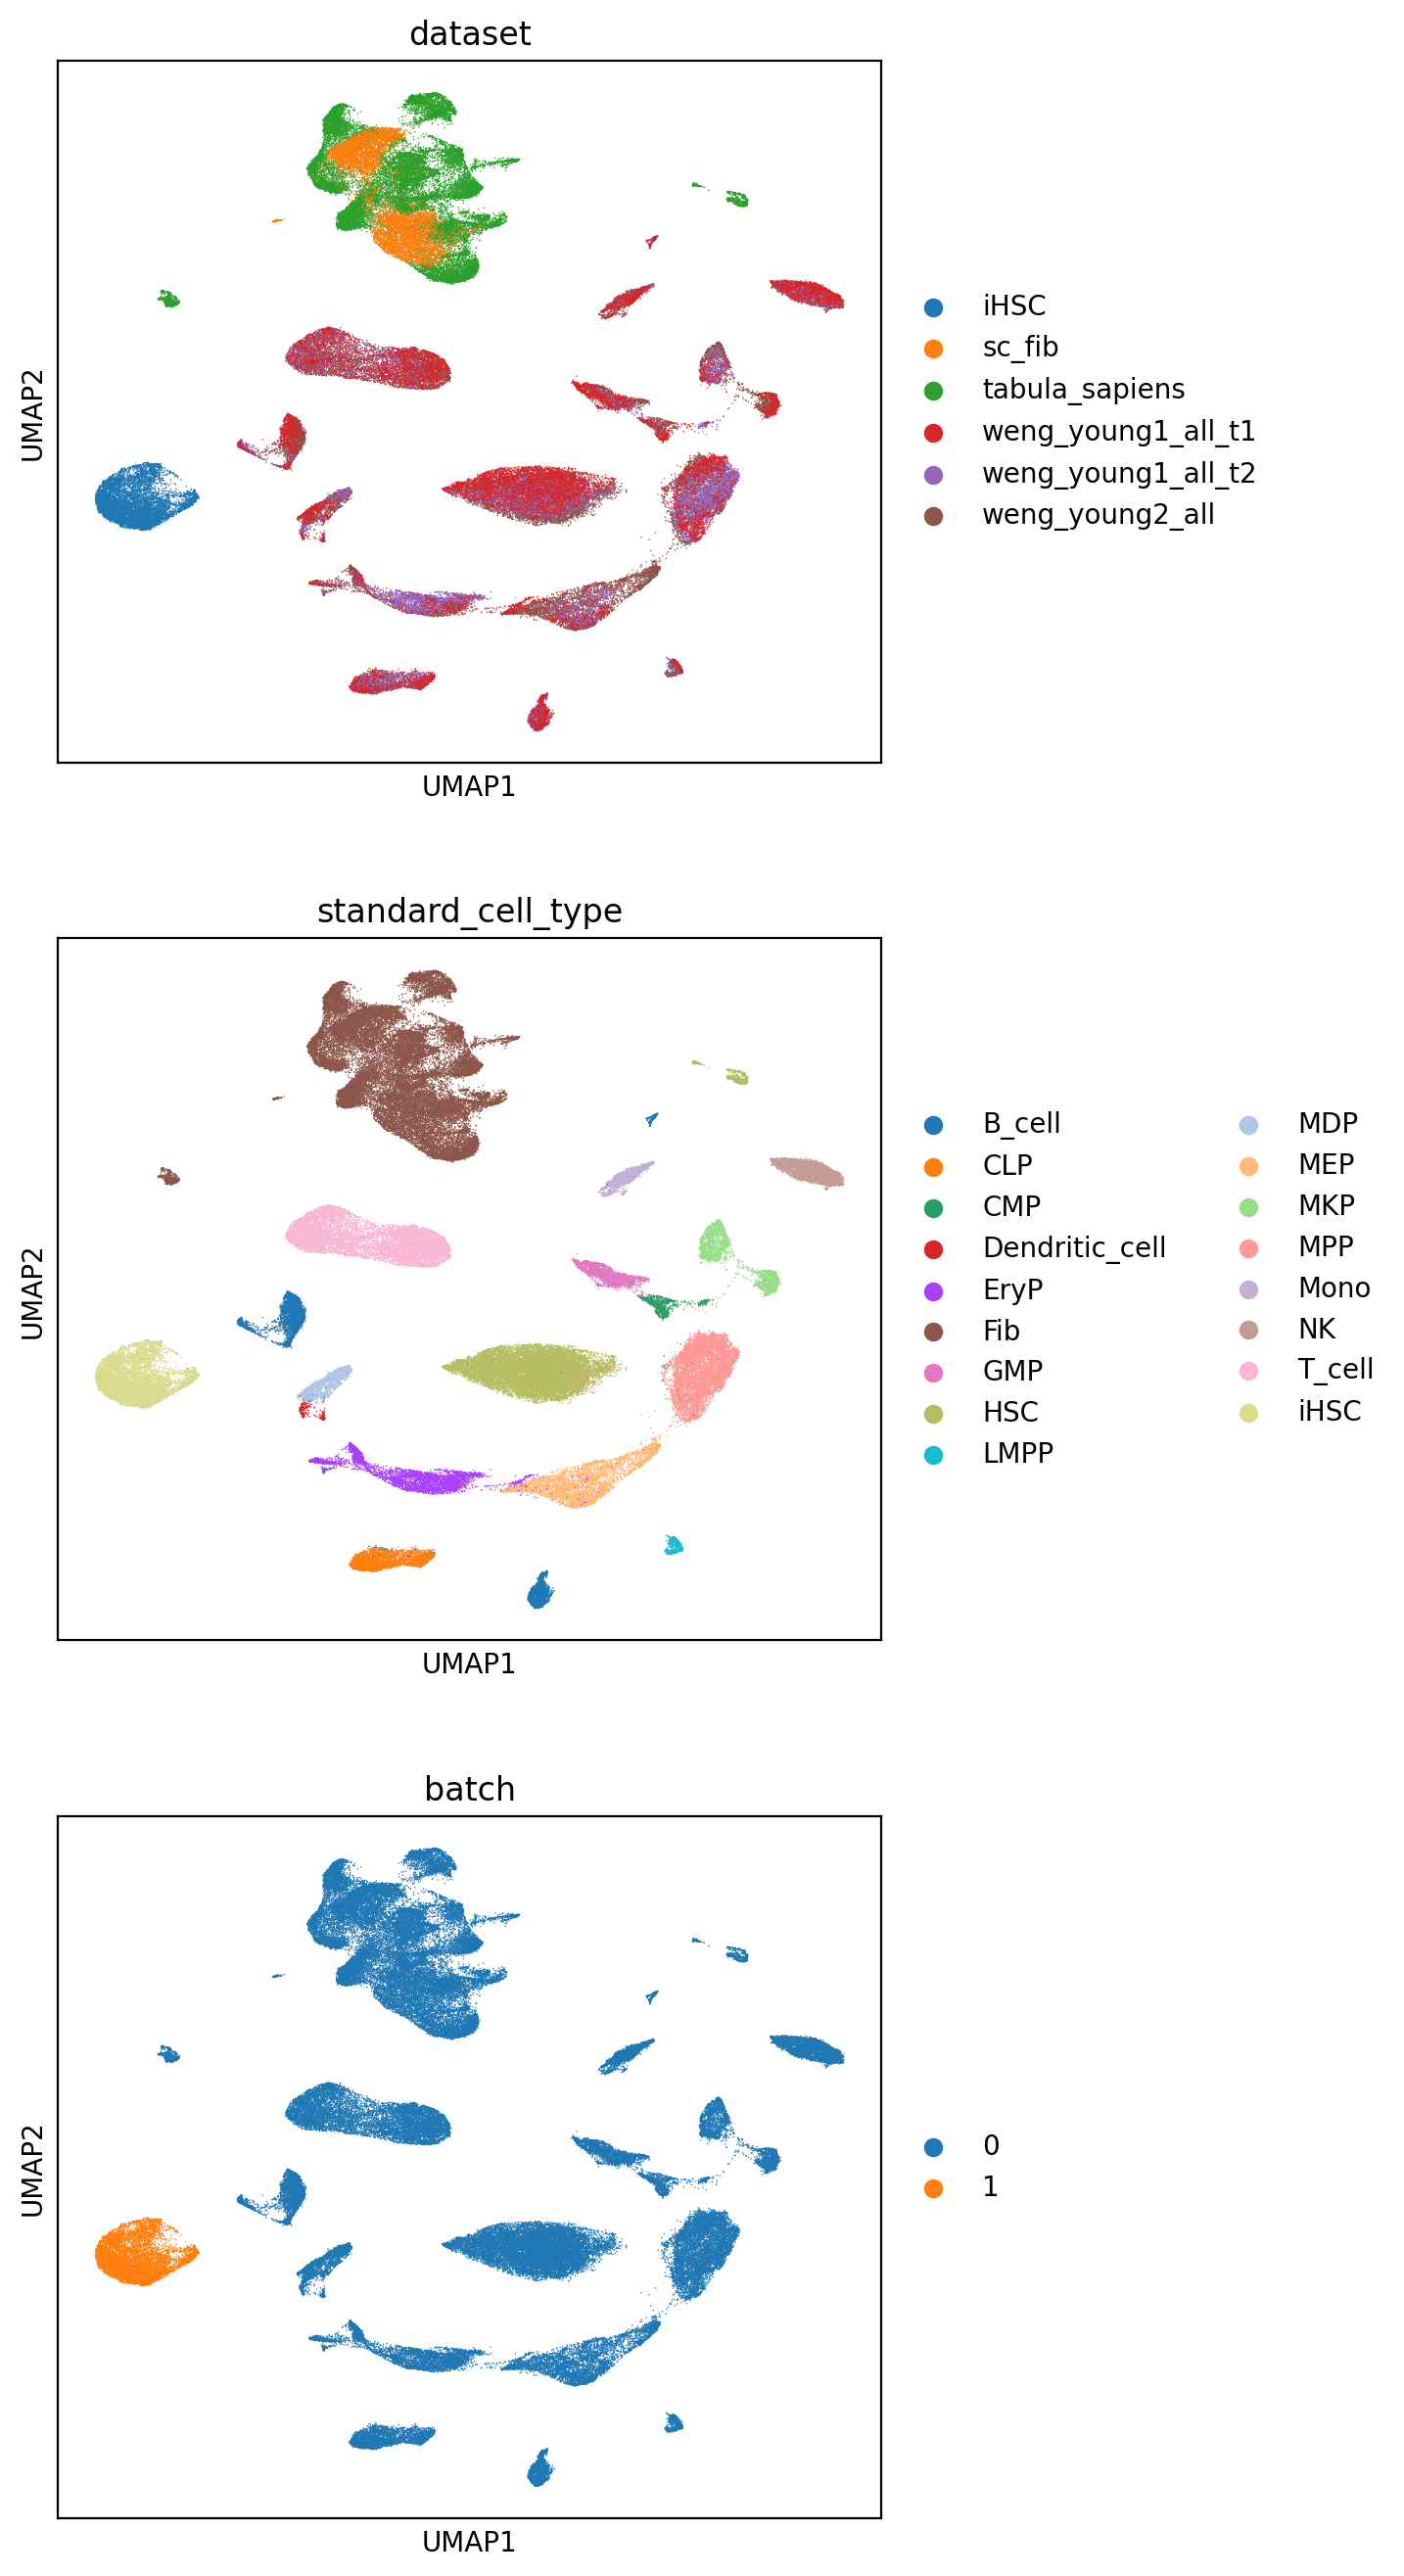

In [35]:
sc.pp.neighbors(
    fdata, 
    use_rep=SCANVI_LATENT_KEY,
)

sc.tl.umap(
    fdata,
    min_dist=0.25,
    method='rapids',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    fdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'batch',
    ],
    ncols=1,
)

# Store ADATA

In [36]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/imputed_data.h5ad"
fdata.write(fpath)
fdata

AnnData object with n_obs × n_vars = 108189 × 2000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    uns: 'neighbors', 'umap', 'dataset_colors', 'standard_cell_type_colors', 'batch_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log_norm', 'SCANVI_counts'
    obsp: 'distances', 'connectivities'